In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# Exact reproduction : 
## Source: https://github.com/michaelmml/Oil-Well-Productivity-SD/blob/main/OilGasProduction.py

(18518, 2)
[[ 0.97941867 52.78932478]
 [ 1.00765468 53.13083338]
 [ 1.07426829 50.28819663]
 [ 1.13323345 48.22145503]
 [ 1.12250554 47.42828035]
 [ 1.16313393 48.49127243]
 [ 1.06821202 46.12692787]
 [ 1.16217585 47.9045025 ]
 [ 1.11777111 46.19459266]
 [ 1.11682344 47.50957245]]
1.138368269447398 45.55645545889103


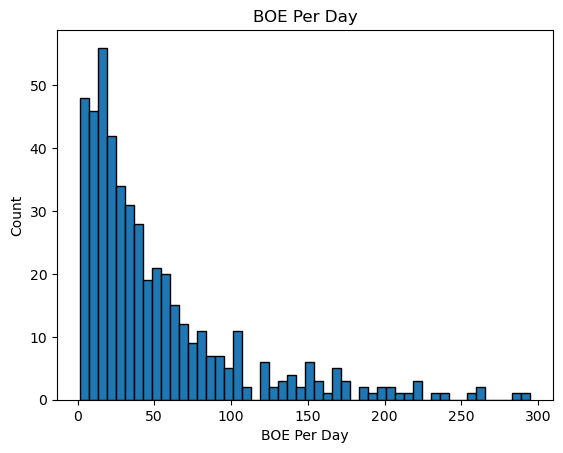

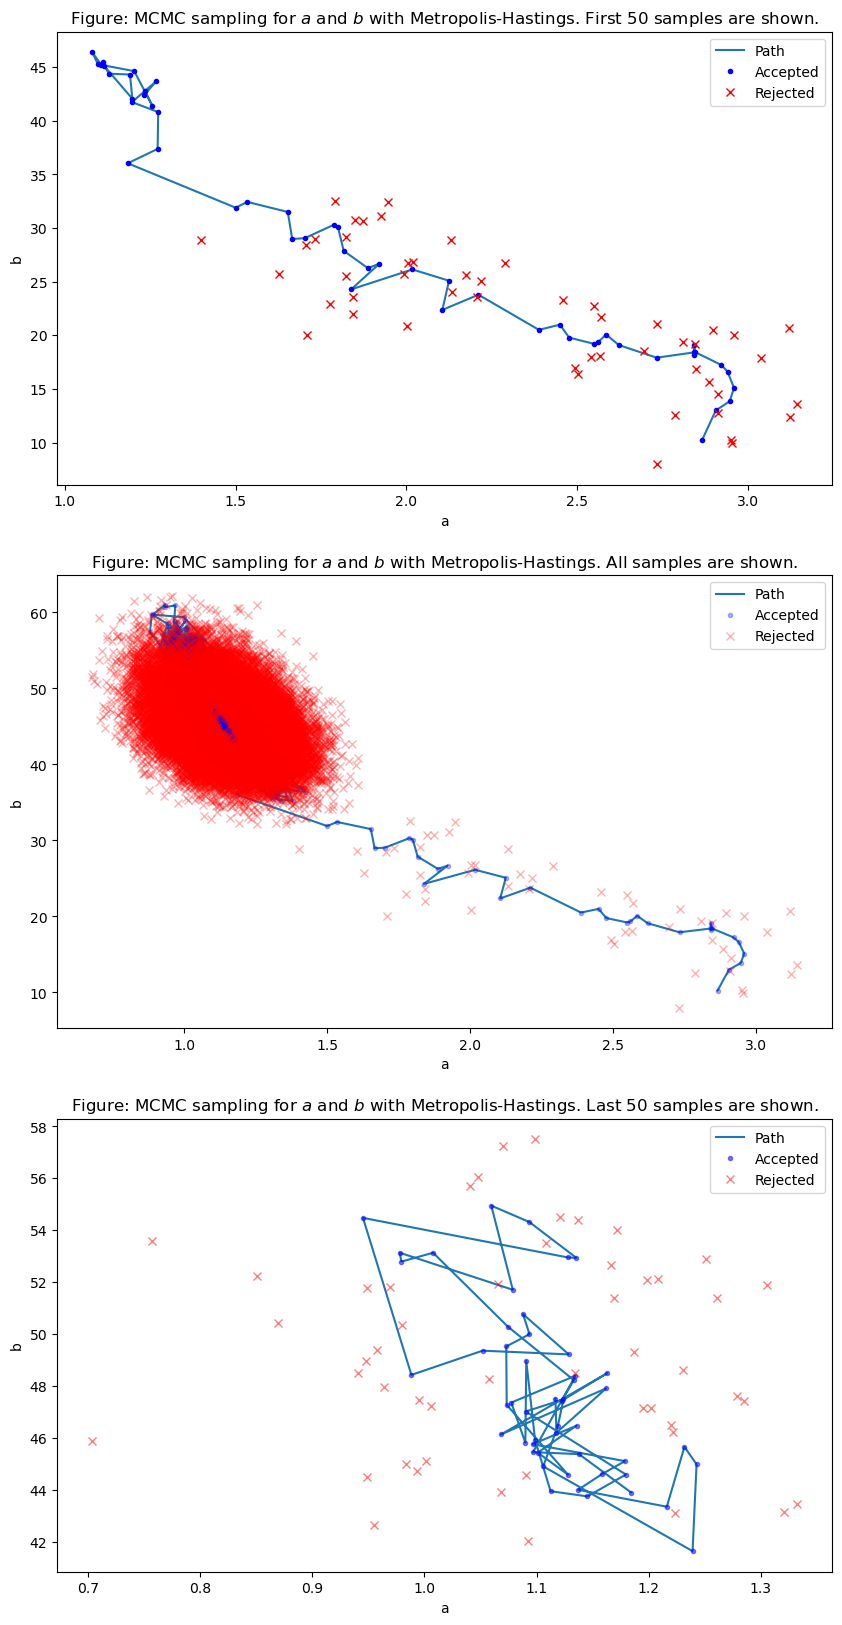

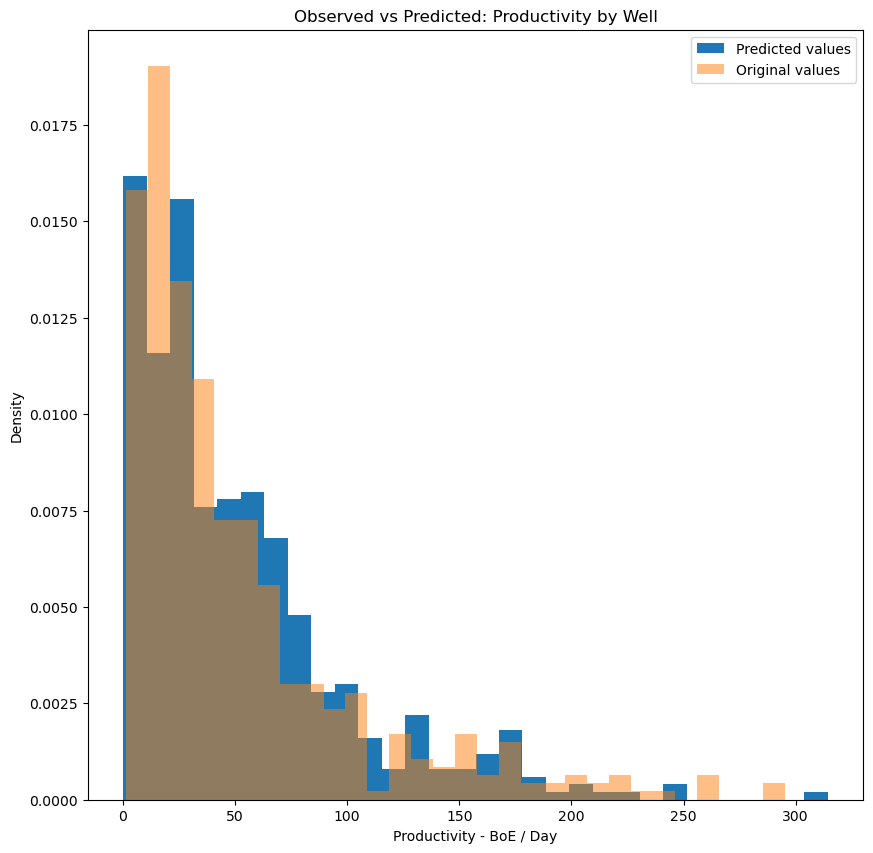

In [5]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import gamma
import math
import csv
import random
import matplotlib.pyplot as plt
# Productivity calculated by (3/4) of total cumulative number of barrels over the number of days to reach that level
allprodrate = pd.read_csv('prodrate.csv')
allprodrate['overallrate'] = (allprodrate['allprodcum'] * (3 / 4)) / allprodrate['allprodthreequarter']

# Removing wells with productivity below 1 barrel per day
allprodrate = allprodrate[(allprodrate['overallrate'] > 1)]

# Histogram

plt.hist(allprodrate['overallrate'].dropna(), bins=50, edgecolor='black');
plt.xlabel('BOE Per Day');
plt.ylabel('Count');
plt.title('BOE Per Day');
plt.savefig('BOE per day.png')

# Monte Carlo Markov Chain with Metropolis-Hastings Algorithm
# Idea from histogram of productivity that the distribution approximates the Gamma Distribution - use of MCMC
# Logarithm for faster computation
def log_gamma(x, data):
    return np.sum(np.log(gamma(a=x[0], scale=x[1], loc=0).pdf(data)))


# Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        return (accept < (np.exp(x_new - x)))

# We need a proposal mechanism which will take us around the space
def proposal(x):
    if x[0] <= 0 or x[1] <= 0:
        return 0
    else:
        return 1


# Essentially, acceptance probability = min(1, dist(y)proposal(x|y)/dist(x)proposal(y|x))
# = min(1, exp(log(dist(y)proposal(x|y)/dist(x)proposal(y|x))
# = min(1, exp(   log(dist(y)) + log(proposal(x|y)) - log(dist(x)) + log(proposal(y|x))   )
# as given in MH function and Acceptance function
def metropolis_hastings(p, q, transition_dist, initial_parameters, iterations, data, accept_rule):
    x = initial_parameters
    accepted = []
    rejected = []
    for i in range(iterations):
        x_new = transition_dist(x)
        if accept_rule(p(x, data) + np.log(q(x)), p(x_new, data) + np.log(q(x_new))):
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)

    return np.array(accepted), np.array(rejected)

# To move x[a,scale] by the normal distribution
transition_pdf = lambda x: np.random.normal(x, [0.1, 2], size = (2,))

accepted, rejected = metropolis_hastings(log_gamma, proposal, transition_pdf, [3, 10], 50000,
                                         allprodrate['overallrate'], acceptance)
print(accepted.shape)
print(accepted[-10:])

# Metropolis_Hastings burn-in and convergence illustration
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(3, 1, 1)
ax.plot(accepted[:50, 0], accepted[:50, 1], label="Path")
ax.plot(accepted[:50, 0], accepted[:50, 1], 'b.', label='Accepted')
ax.plot(rejected[:50, 0], rejected[:50, 1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")
plt.savefig('SD Oil MCMC sampling First 50 samples.png')

ax = fig.add_subplot(3, 1, 2)
ax.plot(accepted[:, 0], accepted[:, 1], label="Path")
ax.plot(accepted[:, 0], accepted[:, 1], 'b.', label='Accepted', alpha=0.3)
ax.plot(rejected[:, 0], rejected[:, 1], 'rx', label='Rejected', alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.")
plt.savefig('SD Oil MCMC All Samples.png')

to_show = 50
ax = fig.add_subplot(3, 1, 3)
ax.plot(accepted[-to_show:, 0], accepted[-to_show:, 1], label="Path")
ax.plot(accepted[-to_show:, 0], accepted[-to_show:, 1], 'b.', label='Accepted', alpha=0.5)
ax.plot(rejected[-to_show:, 0], rejected[-to_show:, 1], 'rx', label='Rejected', alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.")
plt.savefig('SD Oil MCMC sampling Last 50 samples.png')


show = -int(0.5 * accepted.shape[0])

mu = accepted[show:, 0].mean()
sigma = accepted[show:, 1].mean()
print(mu, sigma)

model = lambda t, mu, sigma: np.random.gamma(mu, sigma, t)
t = np.arange(allprodrate['overallrate'].shape[0])
observations = model(t.shape[0], mu, sigma)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

# Histogram of observed productivity and predicted productivity based on Gamma Distribution generated by
# Metropolis-Hastings

ax.hist(observations, histtype='stepfilled', density=True, edgecolor='none', bins=30, label="Predicted values")
ax.hist(allprodrate['overallrate'], histtype='stepfilled', density=True, edgecolor='none', bins=30, alpha=0.5, label="Original values")
ax.set_xlabel("Productivity - BoE / Day")
ax.set_ylabel("Density")
ax.set_title("Observed vs Predicted: Productivity by Well")
ax.legend()
plt.savefig('South Dakota Oil MCMC')

In [6]:
accepted

array([[ 2.86638774, 10.24697633],
       [ 2.90657155, 13.00831309],
       [ 2.94747614, 13.86227914],
       ...,
       [ 1.16217585, 47.9045025 ],
       [ 1.11777111, 46.19459266],
       [ 1.11682344, 47.50957245]])